In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from src.utils.data_utils import *
from src.utils.general_utils import *

C:\Users\pierr\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

# P2: Project proposal and initial analyses
This notbook will present all the main result of the initial analysis and data exploration of the project. We will assess the feasibility of analyzing each line of research, and outline the overall methods we will be considering.

## Data exploration
First, we present a general visualization of the data available in the datasets we use. All these informations could be used at some point in the line of analysis presented below.

The `Movie` contains Metadata information originaly from the Freebase database that are extracted from the *CMU Movie Summary Corpus* dataset. We added informations for each films from the IMDb Non-Commercial Database. (see the `data_preprocessing.ipynb` notebook inside `src\data\data_preprocessing.ipynb`for more information about the merge)

In [6]:
Movie.head(3)

,IMDb_title_ID,release_date,runtime,Primary_title,Original_title,Average rating,number of votes,IMDb_director_ID,IMDb_writers_ID,Producer name,...,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,modified_title_y
1894missjerry,tt0000009,1894,45,Miss Jerry,Miss Jerry,5.4,216.0,nm0085156,nm0085156,Alexander Black,...,10109752,/m/02q23xk,Miss Jerry,1894,<NA>,<NA>,Silent film,United States of America,"Short Film, Silent film, Indie, Black-and-white",missjerry
1897thecorbettfitzsimmonsfight,tt0000147,1897,100,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,5.2,540.0,nm0714557,<NA>,Enoch J. Rector,...,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897,100000.0,<NA>,,,Sports,thecorbettfitzsimmonsfight
1906thestoryofthekellygang,tt0000574,1906,70,The Story of the Kelly Gang,The Story of the Kelly Gang,6.0,938.0,nm0846879,nm0846879,Charles Tait,...,142995,/m/0120y4,The Story of the Kelly Gang,1906,<NA>,70.0,English Language,Australia,"Crime Fiction, Silent film, Biography, Indie, ...",thestoryofthekellygang


In [7]:
print(Movie.shape)

(61042, 26)


In [8]:
Actor.head(3)

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease
0,/m/010p3,Adam Carolla,1964-05-27,M,1.88,Italian Americans,"[/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, ...","[35.0, 35.0, 45.0, 33.0, 33.0, 34.0, 42.0, 35...."
1,/m/010q36,Fred Rogers,1928-03-20,M,NaN,None,[/m/033pf1],[67.0]
2,/m/010wx,Aria Giovanni,1977-11-03,F,1.68,Yugoslavs,[/m/07gx0c],[25.0]


In [9]:
print(Actor.shape)

(135760, 8)


### Distribution of data in the Movie dataset

The dataset contains films between 1910 and 2020. We observe almost twice as many films as usual in the 2000-2015 period.

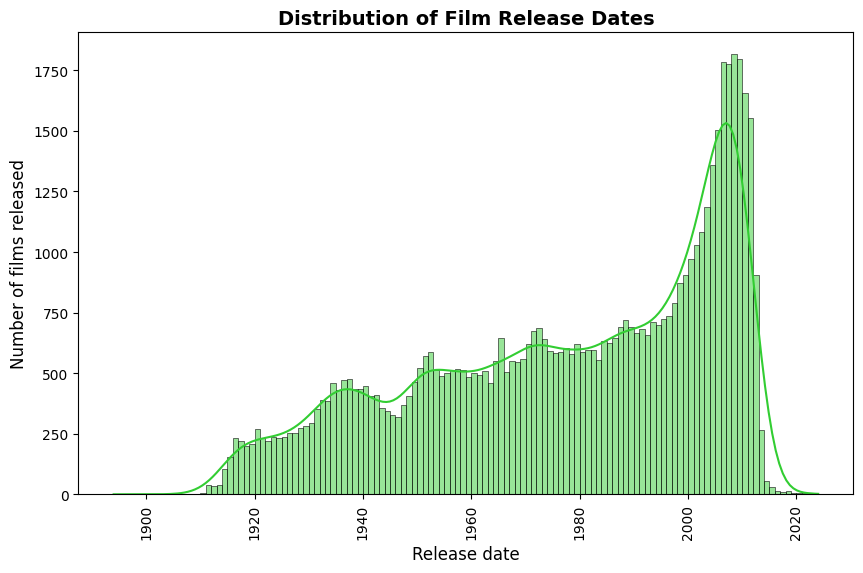

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(Movie, x = "release_date", kde = True, bins = max(Movie.release_date)-min(Movie.release_date), color = "limegreen")
plt.ylabel("Number of films released", fontsize = 12)
plt.xlabel("Released date", fontsize = 12)
plt.xlabel("Release date", fontsize = 12)
plt.xticks(rotation=90)  
plt.title('Distribution of Film Release Dates',fontsize=14, fontweight = "bold")
plt.show()

634 different genres are present. We would typically consider only the 10 most popular genres in our analysis.

The dataset contains 361 different genres.


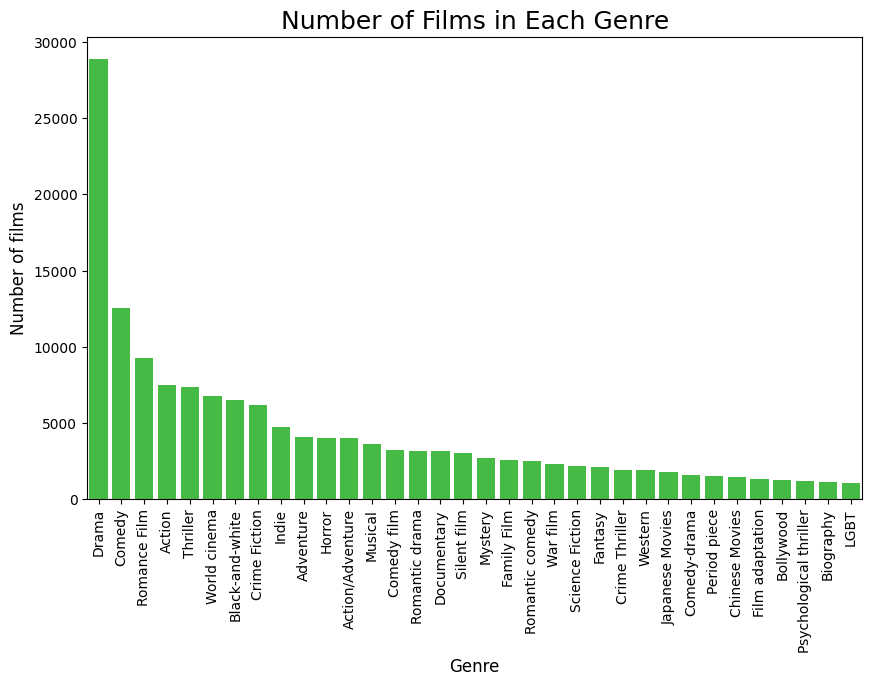

In [14]:
all_genres = Movie['Movie_genres'].str.split(', ')
all_genres = [genre for sublist in all_genres for genre in sublist]

genre_counts = pd.DataFrame(all_genres, columns=['Genre']).value_counts().reset_index()
#Delete the unknown or empty genres
genre_counts = genre_counts[genre_counts["Genre"]!='']
print(f"The dataset contains {len(genre_counts)} different genres.")

genre_counts.columns = ['Genre', 'Count']

#plotting only the genre that are represented more than 1000 times
genre_counts = genre_counts[genre_counts.Count>1000]

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='Genre', y = 'Count', color = "limegreen")
plt.xticks(rotation=90)  
plt.ylabel("Number of films", fontsize = 12)
plt.xlabel("Genre", fontsize = 12)
plt.title('Number of Films in Each Genre', fontsize=18)
plt.show()

145 different countries of origin are present in the dataset. We could group certain countries together (such as European or African countries, for example) to consider only the ~10 most prolific countries. An other posibility is to group the country by their continent for the analysis.

The dataset contains 145 different Country.


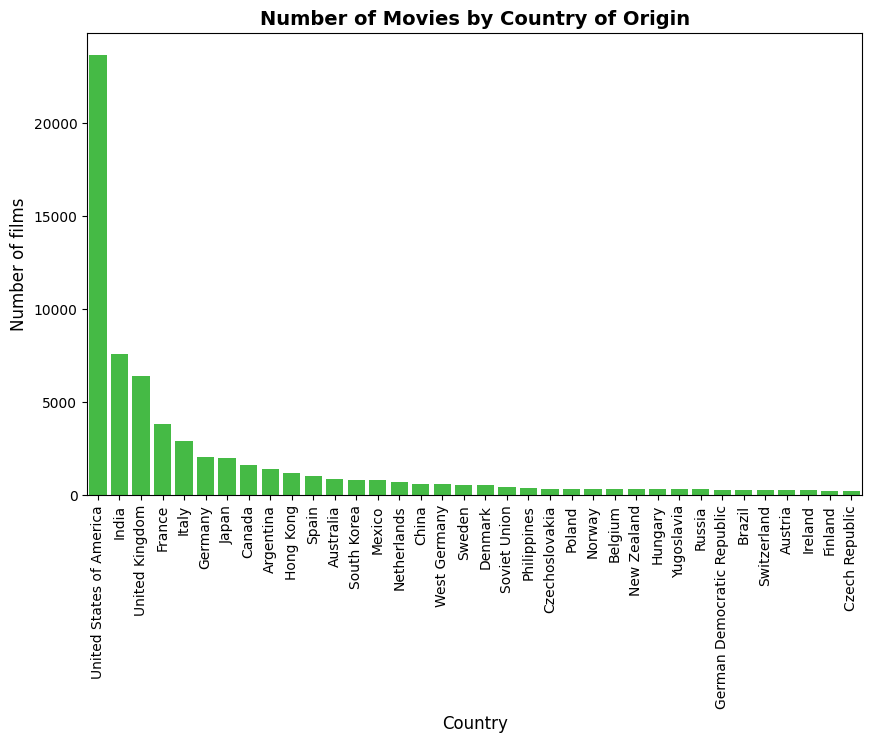

In [16]:
all_country = Movie['Movie_countries'].str.split(', ')
all_country = [Country for sublist in all_country for Country in sublist]
country_counts = pd.DataFrame(all_country).value_counts().reset_index()

country_counts.columns = ['Country', 'Count']

#Delete the unknown or empty genres
country_counts = country_counts[country_counts["Country"]!='']
print(f"The dataset contains {len(country_counts)} different Country.")

#plotting only the country that produce more than 200 movies
country_counts = country_counts[country_counts.Count>200]

plt.figure(figsize=(10, 6))
sns.barplot(data=country_counts, x='Country', y = 'Count', color = "limegreen")
plt.ylabel("Number of films", fontsize = 12)
plt.xlabel("Country", fontsize = 12)
plt.xticks(rotation=90)  
plt.title('Number of Movies by Country of Origin',fontsize=14, fontweight="bold")
plt.show()

### Distribution of data about actors and directors

In [18]:
Director_profile = create_Director_profile(Movie)

After reconverting the ethnicity data, we conclude that we won't be able to do any further analysis using ethnicity as we only have this information for less than 6% of actors. We could typically focus the analysis on the most popular actors (larger networks/careers). We would then double-check whether information on the ethnic origin of this subset of actors could be used.

The dataset contains 426 different ethinicity. We have the ethnicity data of only 7895 (5.815%) actors. 


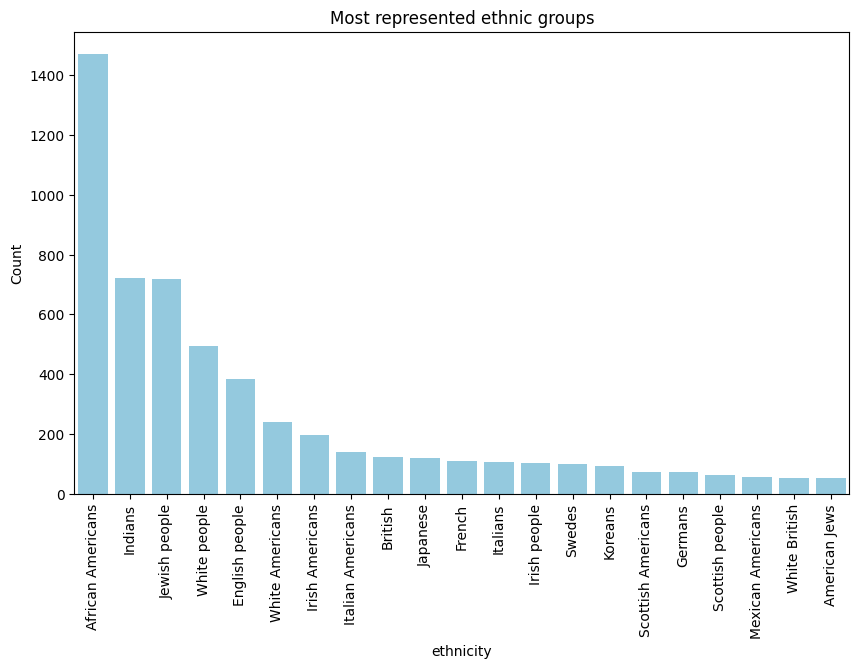

In [20]:
ethnicity = Actor["ethnicity"]
# We have seen that an ethnicity was empty. We checked few samples on internet, and remark that this ethnicity was "Japanese". 
Actor["ethnicity"].replace(inplace=True, value = "Japanese", to_replace='')
ethnicity = ethnicity.dropna()

ethnicity_counts = pd.DataFrame(ethnicity, columns=['ethnicity']).value_counts().reset_index()
ethnicity_counts.columns = ['ethnicity', 'Count']
print(f"The dataset contains {len(ethnicity_counts)} different ethinicity. We have the ethnicity data of only {ethnicity_counts.sum().iloc[1]} ({100*ethnicity_counts.sum().iloc[1]/len(Actor):.3f}%) actors. ")

#plotting the ethnic groups that contains more than 50 actors
ethnicity_counts = ethnicity_counts[ethnicity_counts.Count>50]

plt.figure(figsize=(10, 6))
sns.barplot(data=ethnicity_counts, x='ethnicity', y = 'Count', color='skyblue')
plt.xticks(rotation=90)  
plt.title('Most represented ethnic groups')
plt.show()

We have a clear imbalence between actor's gender in the dataset with 45 % Male and only 26 % Female. Note that we lack this information for 29% of actors.

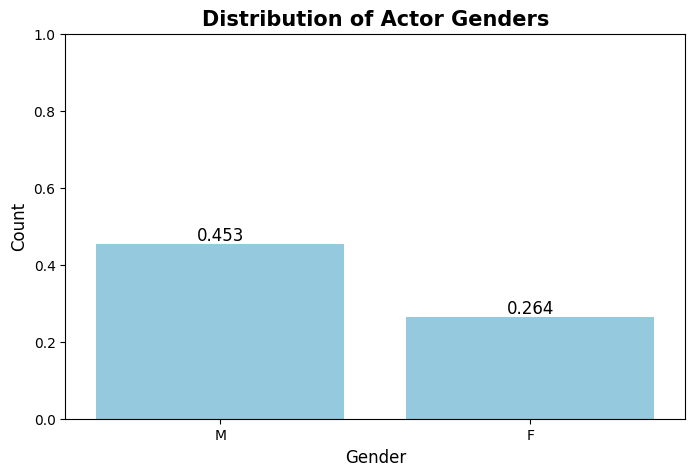

In [22]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=Actor, x='actor_gender', stat = 'proportion', color='skyblue')
plt.title('Distribution of Actor Genders',fontsize=15, fontweight = "bold")
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar (proportion)
    ax.text(p.get_x() + p.get_width() / 2, height, f'{height:.3f}', 
            ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('Gender',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.ylim([0,1])
plt.show()

The dataset includes actors and directors born between 1850 and 2000 reaching a maximal around 1970.

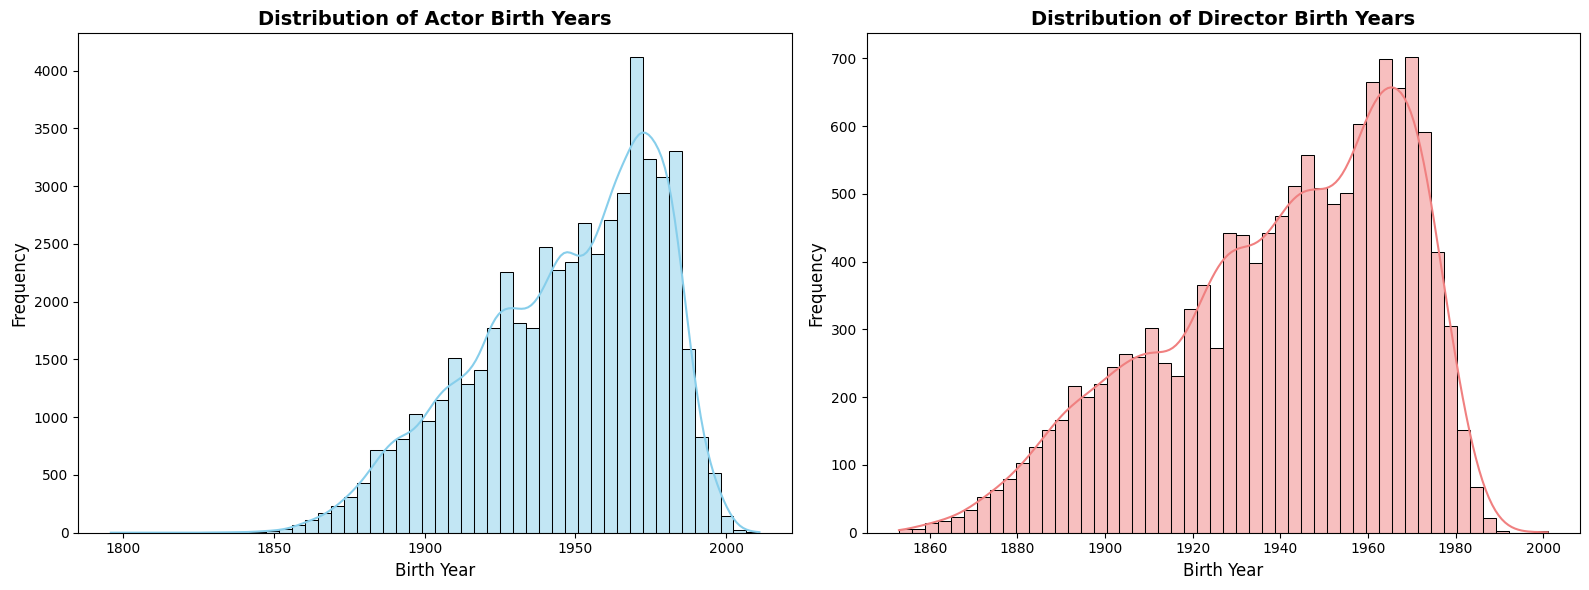

In [24]:
# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

Actor_bis = Actor.copy()

Actor_bis['actor_DOB'] = pd.to_datetime(Actor_bis['actor_DOB'], errors='coerce')
Actor_bis['Birth_Year'] = Actor_bis['actor_DOB'].dt.year

# Actor DOB
sns.histplot(Actor_bis['Birth_Year'].dropna(), kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor Birth Years',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Birth Year',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)


# Director DOB
sns.histplot(Director_profile['birthYear_director'].dropna(), kde=True, bins=50, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director Birth Years',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Birth Year',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Keeping track of the ages of the directors and actors during their career could be interesting. To do so, we use the `age_atmovierelease` columns that we need to clean before plotting the distributions.

In [26]:
Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Computing the start of the actor and director carrer 
# Replace NaN with -1 and ensure all values are integers
Actor_bis["actor_age_atmovierelease"] = Actor_bis["actor_age_atmovierelease"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Actor_bis["Career_Start_age"] = Actor_bis.apply(
    lambda row: min((val for val in row["actor_age_atmovierelease"] if val > 0), default=np.nan),
    axis=1,
)

# Doing the same for the director
Director_bis["age_at_movie_release"] = Director_bis["age_at_movie_release"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Director_bis["Career_Start_age"] = Director_bis.apply(
    lambda row: min((val for val in row["age_at_movie_release"] if val > 0), default=np.nan),
    axis=1,
)

As for ages at movie release, the data is nicely distributed for both actors and directors. We can observe that directors are typically older that the actors. 

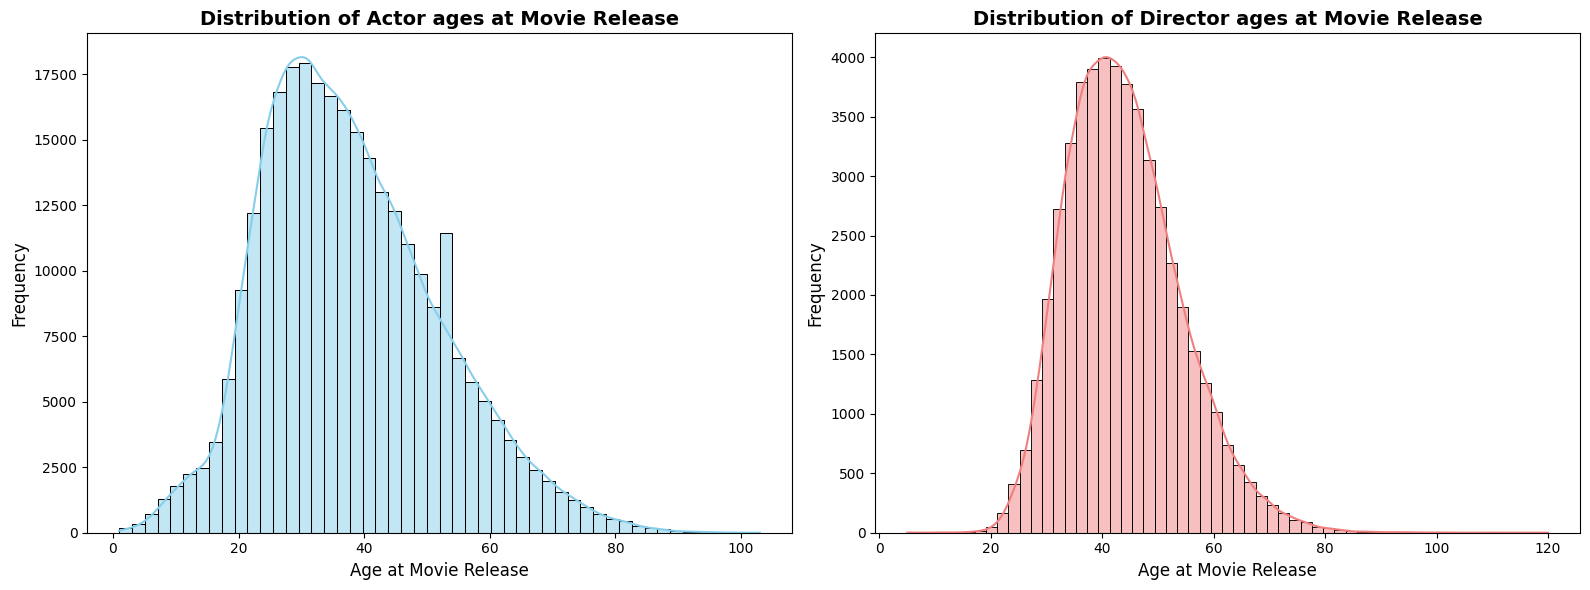

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# Need to explose the dataset as the age at movie release is a list
Actor_explo_age = Actor_bis.explode('actor_age_atmovierelease')
Actor_explo_age = Actor_explo_age[Actor_explo_age["actor_age_atmovierelease"]>0]

Directors_explo_age = Director_bis.explode('age_at_movie_release')
Directors_explo_age = Directors_explo_age[Directors_explo_age["age_at_movie_release"]>0]

# Director age at movie release
sns.histplot(Actor_explo_age['actor_age_atmovierelease'].dropna(), kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor ages at Movie Release',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Age at Movie Release',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Directors_explo_age['age_at_movie_release'].dropna(), kde=True, bins=57, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director ages at Movie Release',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Age at Movie Release',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

We then plot the ages of the director and actor at their debut :

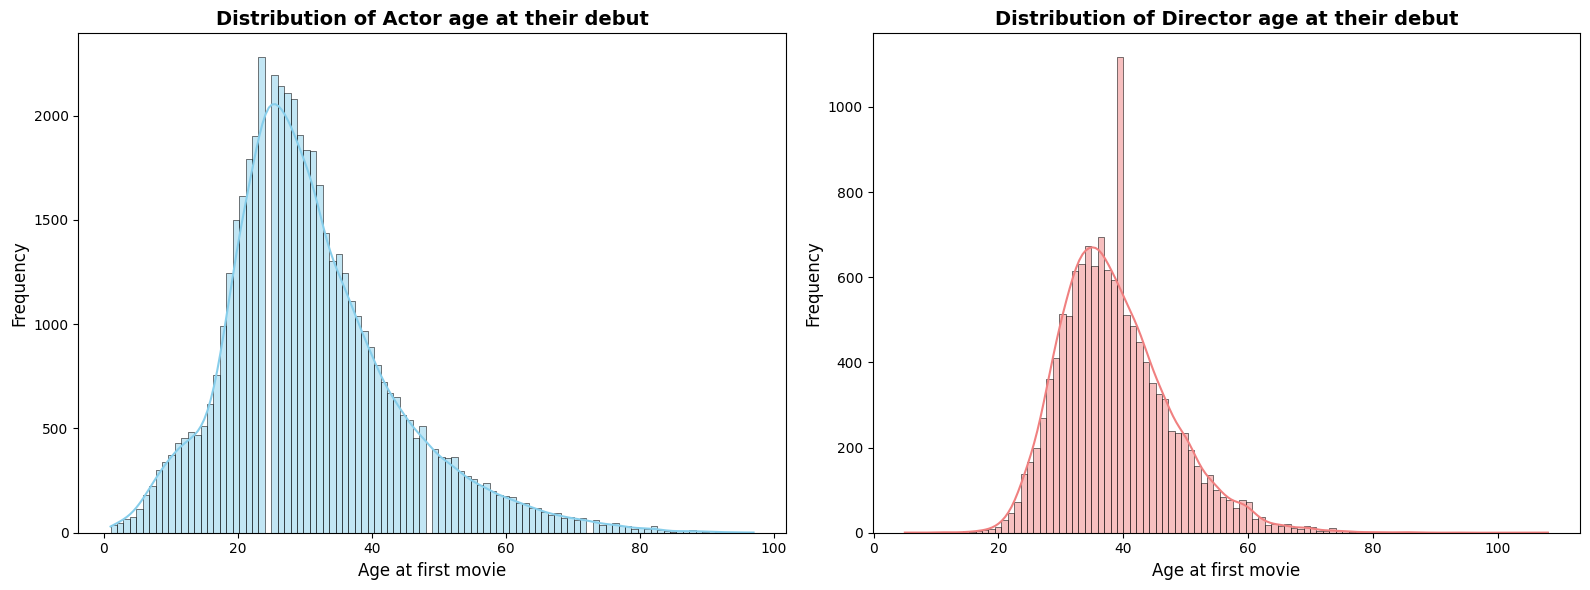

In [30]:
# Plotting the result from the previous cell
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor age at movie release
sns.histplot(Actor_bis["Career_Start_age"].dropna(), kde=True, bins=100, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor age at their debut',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Age at first movie',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Director_bis["Career_Start_age"].dropna(), kde=True, bins=100, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director age at their debut',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Age at first movie',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Both distribution have the same shape but we observe that the director distribution is less spread out. The most represented age is around 25 years old for the actors and 37 years old for the directors.

Then we plot the number of films directed/played by directors/actor.

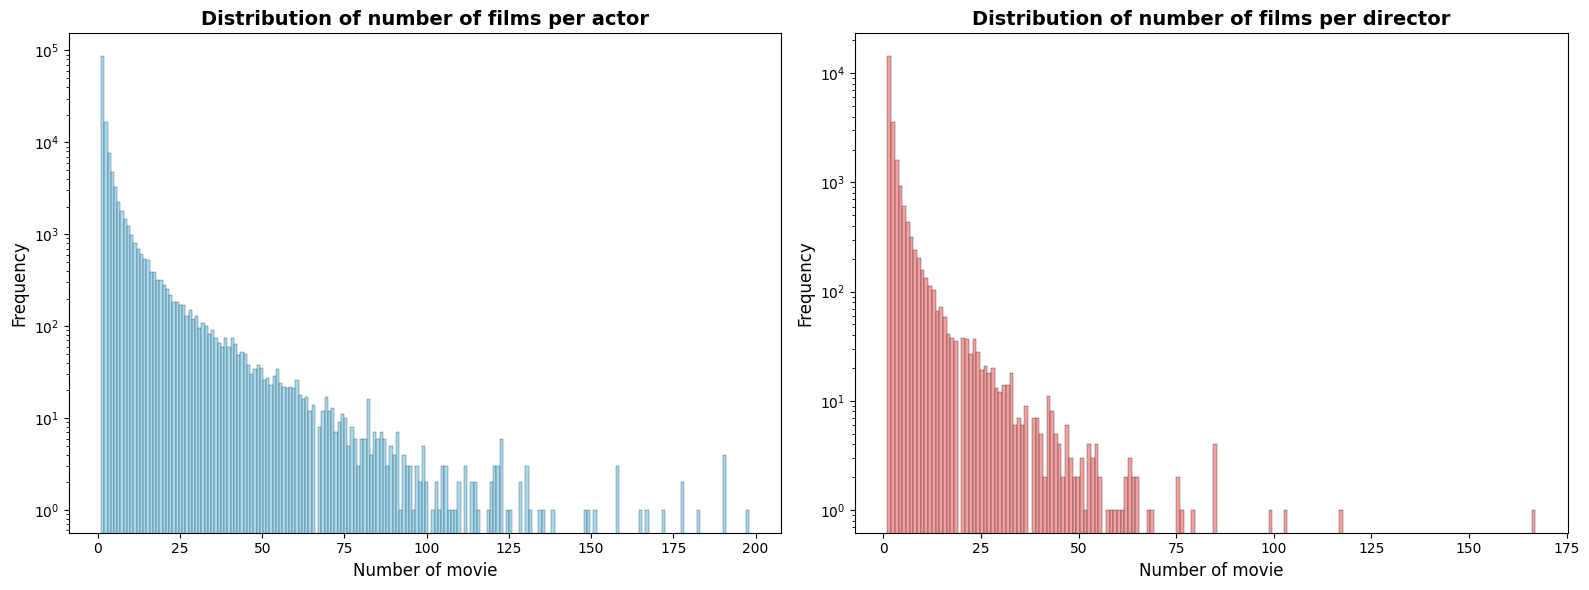

In [33]:
Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Computing the number of films played (directed) by actors (directors)
Actor_bis["Number_of_films"] = Actor_bis["actor_age_atmovierelease"].apply(len)
Director_bis["Number_of_films"] = Director_bis["age_at_movie_release"].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor age at movie release
sns.histplot(Actor_bis[Actor_bis['Number_of_films']<200]['Number_of_films'], bins=200, color='skyblue', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Distribution of number of films per actor',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Number of movie',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Director_bis[Director_bis['Number_of_films']<200]['Number_of_films'], bins=175, color='lightcoral', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Distribution of number of films per director', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Number of movie', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)


# Show the plot
plt.tight_layout()
plt.show()

Typically, the graph for the actor shows that around $10^5$ actors have played in one single film, around $2 \times 10^4$ have played in only two different films,... These two curves are as expected decreasing pretty fast : directors that have directed more than 50 movies or actors that have played in more than 100 movies are isolated case. <br>We can notice that directors tend to participate in fewer films that actors.

## Network and career analysis through time 

The first line of analysis in our project would focus on the evolution of actors' careers and network. More specifically, we will characterize an actor's career in terms of the number of films he has acted in and the number of actors he has acted based on the analysis of thier networks. Then, using, for example, a K-NN clustering algorithm, we will classify actors according to the evolution of their careers/networks. Finally, using this classification, we could analyze the distribution of actors in each class according to the information available on the them, such as gender, ethnic origin, age at the begining of thier career, most country of origin  or genre of the films in their filmography.

The major research question of this line of analysis would be:\
**What are the major factor of characterisation of actors career and network evolution ?**\
Some intermediate questions could be:\
*What type of career/network evolution do we observe ?*\
*Does the career evolution stongly determine the network evolution?*\
*Does gender or ethnicity impact an actor career ? and thier network ?*\
*Is it better to work in America or India to build up a network of contacts? What about career stability (long-term or short-term)?*

Here is the global stategy that we will use to answer these questions:

1) Create networks using the list of actors that played in each film
2) Extract metrics form the networks
3) Create 1 network for each year between 1910 and 2020 and extract the metrics for all actors
4) Use the actors age at movie release to extract the evolution of the number of films each actors played in.
5) Analyse the evolution of the metrics from the networks and the career evolution (number of films they played in)
6) Create clusters on the network metrics evolution and the career evolution using K-NN clustering algorithm and analyse the specification of these cluster
7) Analyse the distribution of gender, ethnicity, age at begining of thier career or most present genre or country of origin of the films in their filmography.

### 1. Create Networks
First we show that we can contruct netwoks between actors how played together with acceptable computation time. (As we would need to do it ~100 times for the full analysis)

Create a network where each node is an Actor ID with a name, gender, ethnicity and height as attributs. The actors are related with edges between actors how played together, the weight of the edges correspond to the number of times they played together. Here we only consider actors that played in more than 5 movies.

In [40]:
start_time = time.time()
print("Created graph with actors:")
played_together = create_actor_network(Actor,Movie,5) 

#remove the nodes that are nans                
nan_nodes = [node for node in played_together.nodes if pd.isna(node)] 
played_together.remove_nodes_from(nan_nodes)

print(f"Number of nodes: {played_together.number_of_nodes()}")
print(f"Number of edges: {played_together.number_of_edges()}")
end_time = time.time()
print(f"Computation time:{time.time()-start_time:.2f}")



Created graph with actors:


Creating network: 100%|██████████| 57355/57355 [00:06<00:00, 8751.03it/s] 
Adding attributes: 270882it [00:28, 9562.29it/s] 

Number of nodes: 16218
Number of edges: 740123
Computation time:36.62


### 2. Extract metrics from the network
Here are the metrics we can extract from the network and the time needed to compute them. Other value such as betweenness_centrality or katz_centrality could also be relevant but are too expensive to compute. We could filter the actors (keeping only the ones that played in at least 50 movie for example) if these metrics are judge indispensable but we would prefer analyse only the degrees (as a measure of the size of the actor network) and the eigenvector_centrality (as an estimation of the centrality of the actor).

In [42]:
start = time.time()
degrees = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.02


Adding the degree of connexion of each actor in the newtork as a new information on the actor

In [44]:
Actor["Degree_final"] = Actor["Freebase_actor_ID"].map(degrees)

In [45]:
start = time.time()
eigenvector_centrality = nx.eigenvector_centrality(played_together) 
print(f"Computation time:{time.time()-start:.2f}")

Computation time:10.24


Adding the eigenvector centrality wich is an estimation of the centrality of the actor in the newtork

In [47]:
Actor["eigenvector_centrality_final"] = Actor["Freebase_actor_ID"].map(eigenvector_centrality)

### 3. Analyse one network for each year

To compute the evolution of these metrics, we create sub graphs by keeping the edges that correspond to films that appears after a specific date. Here we will do it only for the year 2005. All the analysis for 1 year took less that 1 minutes wich indicate that the analysis on the full range (~1910 to 2020) would be feasible

In [50]:
start_time = time.time()
print("Created graph with actors:")
played_together_2005 = create_actor_network(Actor,Movie,5, 2005) 

#remove the nodes that are nans                
nan_nodes = [node for node in played_together_2005.nodes if pd.isna(node)] 
played_together_2005.remove_nodes_from(nan_nodes)

print(f"Number of nodes: {played_together_2005.number_of_nodes()}")
print(f"Number of edges: {played_together_2005.number_of_edges()}")
end_time = time.time()
print(f"Computation time:{time.time()-start_time:.2f}")


Created graph with actors:


Creating network: 100%|██████████| 57355/57355 [00:02<00:00, 27621.37it/s]
Adding attributes: 270882it [00:20, 12905.45it/s]

Number of nodes: 8759
Number of edges: 172850
Computation time:24.38


In [51]:
start = time.time()
degrees_2005 = dict(played_together_2005.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.01


In [52]:
Actor["Degree_2005"] = Actor["Freebase_actor_ID"].map(degrees_2005)

In [53]:
start = time.time()
eigenvector_centrality_2005 = nx.eigenvector_centrality(played_together_2005) 
print(f"Computation time:{time.time()-start:.2f}")

Computation time:9.45


In [54]:
Actor["eigenvector_centrality_2005"] = Actor["Freebase_actor_ID"].map(eigenvector_centrality_2005)

### 4. Analyse the evolution of the metrics given by the networks
After running the analysis, we would end up with graph of the evolution of the network metrics of each actor during there career. Here, as illustration, we just show some actors that have hudge differences is the number of connexion and position in the network before and after 2005.

In [56]:
Actor["degree_evolution"] = (Actor.Degree_final - Actor.Degree_2005)
Actor["centrality_evolution"] = (Actor.eigenvector_centrality_2005 - Actor.eigenvector_centrality_final)

In [57]:
Actor.nlargest(n=5,columns=["degree_evolution"])

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease,Degree_final,eigenvector_centrality_final,Degree_2005,eigenvector_centrality_2005,degree_evolution,centrality_evolution
135751,/m/0ywqc,Donald Sutherland,1935-07-17,M,1.93,Scottish Americans,"[/m/0dcjzb, /m/02vxyq9, /m/0h1d4kn, /m/01vg4x,...","[69.0, 68.0, <NA>, 65.0, 34.0, 43.0, 58.0, 40....",745.0,0.052905,148.0,0.002687,597.0,-0.050219
100213,/m/0gnbw,Michael Caine,1933-03-14,M,1.88,None,"[/m/03m5fv7, /m/016ks5, /m/02qsvdf, /m/076yzh_...","[53.0, <NA>, 68.0, 76.0, 55.0, 60.0, 41.0, 57....",749.0,0.043374,161.0,0.003125,588.0,-0.040249
7516,/m/02gf_l,Frank Welker,1946-03-12,M,1.73,None,"[/m/09fl_w, /m/02wwhrp, /m/08gshh, /m/02wbq9_,...","[30.0, 61.0, 51.0, 44.0, 44.0, 40.0, 63.0, <NA...",665.0,0.040383,101.0,0.001590,564.0,-0.038793
381,/m/015p3p,Harry Dean Stanton,1926-07-14,M,1.727,None,"[/m/06g77c, /m/0289n83, /m/07q1m, /m/015p4j, /...","[80.0, 65.0, 72.0, 40.0, 46.0, 84.0, 76.0, 47....",650.0,0.048477,90.0,0.001705,560.0,-0.046772
492,/m/016ks_,James Woods,1947-04-18,M,1.803,None,"[/m/05lvfp, /m/04x4v5, /m/02bqvb, /m/0kvfz9, /...","[27.0, 49.0, 35.0, 29.0, 52.0, 33.0, 60.0, 62....",644.0,0.050278,84.0,0.000929,560.0,-0.049349


In [58]:
Actor.nlargest(n=5,columns=["centrality_evolution"])

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease,Degree_final,eigenvector_centrality_final,Degree_2005,eigenvector_centrality_2005,degree_evolution,centrality_evolution
7131,/m/0292l3,Anupam Kher,1955-03-07,M,NaN,Kashmiri Pandit,"[/m/0bmh28z, /m/0h2zvzr, /m/0h71c9n, /m/03gzss...","[55.0, <NA>, 35.0, 47.0, 43.0, 53.0, 44.0, 42....",623.0,0.005129,353.0,0.129607,270.0,0.124478
27264,/m/05qtcv,Rajpal Yadav,1971-03-16,M,1.6,None,"[/m/052172r, /m/0d2xnb, /m/047f13w, /m/03mbq0n...","[40.0, 34.0, 36.0, 31.0, 34.0, 32.0, 33.0, <NA...",342.0,0.001644,263.0,0.115751,79.0,0.114107
16021,/m/03m2fg,Sanjay Dutt,1959-07-29,M,1.83,Indians,"[/m/03cz5_p, /m/080c6tv, /m/0f42nz, /m/0h71c9n...","[48.0, 39.0, 48.0, 30.0, 40.0, 23.0, 44.0, 51....",426.0,0.001728,247.0,0.114340,179.0,0.112612
35347,/m/07yw6t,Paresh Rawal,1950-05-30,M,1.83,Gujarati people,"[/m/0db_xm, /m/0d2xnb, /m/0924qt, /m/0h71c9n, ...","[54.0, 55.0, 52.0, 39.0, 58.0, 50.0, 42.0, 49....",487.0,0.001956,238.0,0.103170,249.0,0.101214
10623,/m/02tq2r,Akshay Kumar,1967-09-09,M,1.85,Indians,"[/m/0924qt, /m/0f42nz, /m/03mb5cp, /m/0gfh97x,...","[34.0, 40.0, 29.0, 25.0, 27.0, 31.0, 27.0, 27....",351.0,0.002033,223.0,0.101737,128.0,0.099705


### 4. Analyse actor's career evolution (number of films they played in)
Here we compute the career evolution of actors. Show that this is feasible and plot the resulting information that we can get.

First we need to clean the `actor_age_atmovierelease` column of the `Actor` dataset.

In [5]:
Actor["actor_age_atmovierelease"] = Actor["actor_age_atmovierelease"].apply(
    lambda x: [pd.NA if pd.isna(age) else int(age) for age in x]
)

Actor["actor_age_atmovierelease"] = Actor["actor_age_atmovierelease"].apply(
    lambda x: [-1 if (pd.isna(val) or val < 0) else val for val in x]
)

Actor["Career_Start_age"] = Actor.apply(
    lambda row: min([val for val in row["actor_age_atmovierelease"] if val > 0], default=-1),
    axis=1,
)

max_career_years = int(max(Actor.apply(lambda row: max(row["actor_age_atmovierelease"]),axis=1)-Actor["Career_Start_age"]))

year_columns = [f"Year_{i}" for i in range(max_career_years)]
Actor_career = pd.concat(
    [Actor.copy(), pd.DataFrame(0, index=Actor.index, columns=year_columns)], axis=1)


Then we count the number of films in each year of an actor carrer

In [9]:
def fill_career_years(row):

    age_at_release = np.array(row["actor_age_atmovierelease"])
    counts = np.zeros(max_career_years+1)
    
    if len(age_at_release) != 0:
        for year in age_at_release:
            if year >= 0 and row["Career_Start_age"]>=0:
                counts[year-row["Career_Start_age"]] += 1
                    
    return counts

In [11]:
start = time.time()
career_counts = np.array(Actor_career.apply(fill_career_years, axis=1).tolist())

for i in range(max_career_years):
    Actor_career[f"Year_{i+1}"] = career_counts[:, i]
print(f"Computation time: {time.time()-start:.2f}s")

Computation time: 5.65s


The results are this kind of graphs showing the evolution of the carrer of an actor. 

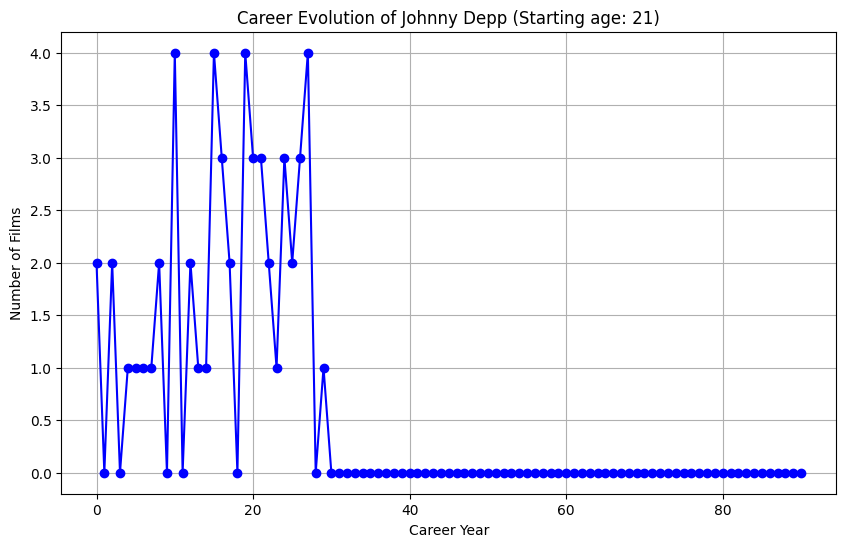

In [18]:
actor_index = Actor_career[Actor_career["actor_name"]=="Johnny Depp"].index[0]

actor_career = career_counts[actor_index]


plt.figure(figsize=(10, 6))
plt.plot(range(0, max_career_years + 1), actor_career, marker='o', color='b', label='Films per year')

plt.xlabel('Career Year')
plt.ylabel('Number of Films')
plt.title(f"Career Evolution of {Actor_career['actor_name'].iloc[actor_index]} (Starting age: {Actor_career['Career_Start_age'].iloc[actor_index]})")
plt.grid(True)

plt.show()

### 5-6-7 K-NN analysis and statistical distribution analysis
The rest of the analysis wont be shown on the notebook but the feasability can be still estimated. In fact, the team `Lovelace` from last year did a similar analyis (K-NN + statistical analysis on distribution of gender in each class) on the career evolution (number of films each year) of actors. For this reason, we think that the K-NN clustering analysis should be feasible for the evolution of the network metrics.

## Relationship between actors and directors

The final axes of our analysis is directed towards the relationship between actors and directors. The directors of each movie were previously found with the IMDb dataset. Only little information about each directors were found, such as date of birth/death, name, as well as the list of movie they directed.

The goal of this part would be to link the actors who were successful during their career to directors using directed graph. The directed graph would be from the actor to the director. The weight of each edge would be the number of movies were the actor and the director were together. The value at the node of the director would be the sum of all the edge coming to him. By doing so, we hope to analyse the link between successful actors and directors and see if directors which have higher value have better carrer or not and if the actors around them as well. The career and successfullnes of actors would be quantify as part of the first research question ("Network and career analysis through time").

The major research question of this line of analysis would be:\
**What are the link between successfull actor and directors ?**

Some intermediate questions could be:\
What is the definition of a successfull actor ?\


Here is the global stategy that we will use to answer these questions:
1. Determine what is a successful actor
2. See the relation between actors and directors
3. Network between actors and directors
4. 